# Credit Scoring – Modeling & Evaluation

## Objectifs
- Entraîner plusieurs modèles de classification
- Comparer leurs performances sur le risque de défaut
- Identifier le meilleur compromis performance / interprétabilité
- Préparer le modèle pour un usage opérationnel

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import os
from joblib import load, dump


In [33]:
preprocessor = load("../data/models/preprocessor.pkl")

X_train, X_test, y_train, y_test = load("../data/models/train_test_split.pkl")

In [34]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        "Model": model_name,
        "AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    
    return metrics


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      5095
           1       0.49      0.76      0.60      1422

    accuracy                           0.78      6517
   macro avg       0.71      0.77      0.72      6517
weighted avg       0.83      0.78      0.79      6517



c:\Users\GENERAL STORES-SARL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


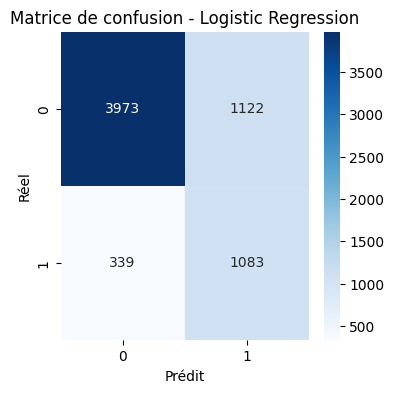

In [35]:
logit = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logit.fit(X_train, y_train)

results = []
results.append(evaluate_model(logit, X_test, y_test, "Logistic Regression"))


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5095
           1       0.84      0.74      0.79      1422

    accuracy                           0.91      6517
   macro avg       0.88      0.85      0.87      6517
weighted avg       0.91      0.91      0.91      6517



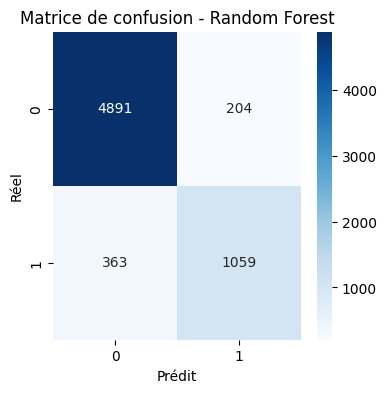

In [36]:
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)
results.append(evaluate_model(rf, X_test, y_test, "Random Forest"))


===== XGBoost =====
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.98      0.72      0.83      1422

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.94      0.93      6517



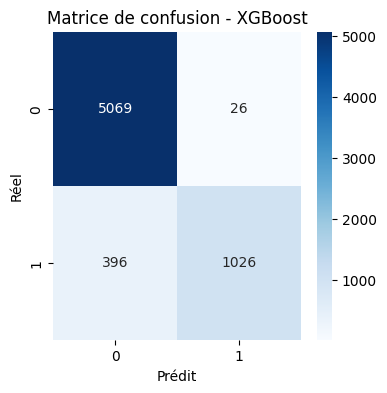

In [37]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
results.append(evaluate_model(xgb, X_test, y_test, "XGBoost"))


[LightGBM] [Info] Number of positive: 5686, number of negative: 20378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\GENERAL STORES-SARL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\GENERAL STORES-SARL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== LightGBM =====
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5095
           1       0.85      0.80      0.82      1422

    accuracy                           0.92      6517
   macro avg       0.90      0.88      0.89      6517
weighted avg       0.92      0.92      0.92      6517



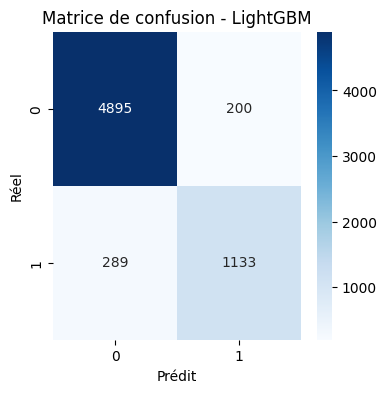

In [38]:
lgbm = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        class_weight="balanced",
        random_state=42
    ))
])

lgbm.fit(X_train, y_train)
results.append(evaluate_model(lgbm, X_test, y_test, "LightGBM"))


In [39]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="AUC", ascending=False)

,Model,AUC,Accuracy,Precision,Recall,F1
3,LightGBM,0.951970,0.924965,0.849962,0.796765,0.822505
2,XGBoost,0.949955,0.935246,0.975285,0.721519,0.829426
1,Random Forest,0.925692,0.912997,0.838480,0.744726,0.788827
0,Logistic Regression,0.843585,0.775817,0.491156,0.761603,0.597188


## Choix du modèle final

Dans un contexte de credit scoring, les faux négatifs
(mauvais clients acceptés) génèrent un coût financier
nettement supérieur aux faux positifs (bons clients refusés).

L’objectif prioritaire est donc de maximiser le recall
sur la classe défaut, afin de détecter le plus grand nombre
possible de clients à risque.

Parmi les modèles testés, LightGBM présente :
- le recall le plus élevé,
- une réduction significative des faux négatifs,
- une performance globale (AUC) satisfaisante.

Ce modèle est donc retenu comme modèle final, sous réserve
d’une analyse approfondie de son explicabilité et d’une
validation métier des seuils de décision.

In [40]:
# Dossier de sauvegarde
model_dir = "../data/models"
os.makedirs(model_dir, exist_ok=True)

# Sauvegarde du pipeline complet
dump(lgbm, os.path.join(model_dir, "final_model_lgbm.pkl"))

# Sauvegarde du nom du modèle retenu (traçabilité)
dump("LightGBM", os.path.join(model_dir, "model_name.pkl"))

print("✅ Modèle LightGBM sauvegardé avec succès.")

✅ Modèle LightGBM sauvegardé avec succès.
